This is the final submission made to the Part 1 of following competition:

https://www.hackerearth.com/challenges/competitive/IIT-Madras-Sangam-ML-Hackathon-2019/

This scored 99.97506 on Public Leaderboard (Rank 34 out of 3169):

https://www.hackerearth.com/challenges/competitive/IIT-Madras-Sangam-ML-Hackathon-2019/leaderboard/predict-the-traffic-volume-1761f3b1/

In [1]:
from math import sqrt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor

%matplotlib inline

In [2]:
def get_missing_data_in_percent(df):
    return df.isna().sum() * 100/len(df)

def plot_data_points_per_day(df, date_feature_name, start_date='2017-02-01', stop_date='2018-07-31', fig_size_tuple=(20,6)):
    '''
    Plot number of data points per day. 
    This is helpful to indicate if there are equal number of data points per day
    df : DataFrame
    date_feature_name : Name of the feature which needs to be plotted
    start_date : Start date of the date range
    stop_date :  End date of the date range
    fig_size_tuple : Size of the figure
    '''
    date_range = pd.date_range(start_date, stop_date)
    number_of_rows_by_date = df[date_feature_name].value_counts().reindex(date_range, fill_value=0)
    plt.figure(figsize=fig_size_tuple)
    plt.plot(number_of_rows_by_date, '.')
    plt.xticks(rotation=90)
    plt.title("Number of data points per day")
    plt.xlabel("Date")
    plt.ylabel("Number of data points")
    plt.show()
    
def rmsle(y, y0):
    return np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y0))))

def encode(data, col, max_val):
    """
    https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
    """
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

def create_date_features(df, temporal_feature_name):
    df['hour'] = df[temporal_feature_name].dt.hour
    df['day'] = df[temporal_feature_name].dt.day
    df['week'] = df[temporal_feature_name].dt.week
    df['month'] = df[temporal_feature_name].dt.month
    df['year'] = df[temporal_feature_name].dt.year
    df['quarter'] = df[temporal_feature_name].dt.quarter
    df['dayofyear'] = df[temporal_feature_name].dt.dayofyear
    #df['weekofyear'] = df[temporal_feature_name].dt.weekofyear
    df['dayofweek'] = df[temporal_feature_name].dt.dayofweek
    df['is_month_start'] = df[temporal_feature_name].dt.is_month_start
    df['date'] = df[temporal_feature_name].dt.date
    df['month_year'] = df[temporal_feature_name].dt.to_period('M')
    #df['days_since'] = (df[temporal_feature_name] - pd.datetime(2012, 1, 1)).dt.days
    return df

In [3]:
DATA_DIR = '../input'

train = pd.read_csv(f'{DATA_DIR}/train/Train.csv', parse_dates=['date_time'])
test = pd.read_csv(f'{DATA_DIR}/test/Test.csv', parse_dates=['date_time'])
sample_submission = pd.read_csv(f'{DATA_DIR}/sample_submission/sample_submission.csv')

combined_df = pd.concat([train.drop('traffic_volume', axis=1), test])
train_index = train.shape[0]

print(f'Shape of train : {train.shape}')
print(f'Shape of test : {test.shape}')
print(f'Shape of sample submission : {sample_submission.shape}' )
print(f'Shape of combined : {combined_df.shape}' )

# Create features based on dates
combined_df = create_date_features(combined_df, 'date_time')

combined_df = encode(combined_df, 'hour', 23)
combined_df = encode(combined_df, 'dayofweek', 6)
combined_df = encode(combined_df, 'month', 12)

# Following didn't work 
#combined_df = encode(combined_df, 'dayofyear', 366)
#combined_df = encode(combined_df, 'day', 31)
#combined_df = encode(combined_df, 'week', 53)
#combined_df = encode(combined_df, 'quarter', 4)


# Log of different features
features_for_logging = ['wind_speed', 'wind_direction', 'snow_p_h', 'rain_p_h', 'humidity']
for feature in features_for_logging:
    feature_name = f'{feature}_log'
    combined_df[feature_name] = np.log1p(combined_df[feature])

# Feature for holidays
combined_df['holiday_binary'] = np.where(combined_df.is_holiday == 'None', 0, 1)

# Feature for weather
combined_df['weather_description_mod'] = combined_df.weather_description.str.lower().str.strip()
weather_type_df = pd.get_dummies(combined_df.weather_type)
combined_df = pd.concat([combined_df, weather_type_df], axis=1)

for name in ['weather_description_mod']:
    feature_name = name + '_le'
    le = LabelEncoder()
    combined_df[feature_name] = le.fit_transform(combined_df[name])
    
# Feature for is_month_start_num
combined_df['is_month_start_num'] = np.where(combined_df.is_month_start == False, 1, 0)

Shape of train : (33750, 15)
Shape of test : (14454, 14)
Shape of sample submission : (4, 2)
Shape of combined : (48204, 14)


In [4]:
# Following didn't help

# combined_df['temp_max_24'] = combined_df.temperature.rolling(window=24, min_periods=1).aggregate('max')
# combined_df['temp_min_24'] = combined_df.temperature.rolling(window=24, min_periods=1).aggregate('min')
# combined_df['temp_std_24'] = combined_df.temperature.rolling(window=24, min_periods=1).aggregate('std')
# combined_df['temp_mean_24'] = combined_df.temperature.rolling(window=24, min_periods=1).aggregate('mean')

# combined_df['humidity_max_24'] = combined_df.humidity.rolling(window=2, min_periods=1).aggregate('max')
# combined_df['humidity_std_24'] = combined_df.humidity.rolling(window=2, min_periods=1).aggregate('std')
# combined_df['humidity_mean_24'] = combined_df.humidity.rolling(window=2, min_periods=1).aggregate('mean')
# combined_df['humidity_min_24'] = combined_df.humidity.rolling(window=2, min_periods=1).aggregate('min')

# combined_df['rain_ph_max_24'] = combined_df.rain_p_h.rolling(window=2, min_periods=1).aggregate('max')
# combined_df['rain_ph_std_24'] = combined_df.rain_p_h.rolling(window=2, min_periods=1).aggregate('std')
# combined_df['rain_ph_mean_24'] = combined_df.rain_p_h.rolling(window=2, min_periods=1).aggregate('mean')
# combined_df['rain_ph_min_24'] = combined_df.rain_p_h.rolling(window=2, min_periods=1).aggregate('min')

In [5]:
window_size = 2

combined_df['lag_dayofyear_1'] = combined_df.dayofyear.shift(window_size)
combined_df['lag_dayofyear_1'].fillna(0, inplace=True)

combined_df['lag_day_1'] = combined_df.day.shift(window_size)
combined_df['lag_day_1'].fillna(0, inplace=True)

combined_df['lag_hour_1'] = combined_df.hour.shift(window_size)
combined_df['lag_hour_1'].fillna(0, inplace=True)

combined_df['lag_week_1'] = combined_df.week.shift(window_size)
combined_df['lag_week_1'].fillna(0, inplace=True)

combined_df['lag_dayofweek_1'] = combined_df.dayofweek.shift(window_size)
combined_df['lag_dayofweek_1'].fillna(0, inplace=True)

combined_df['lag_wind_direction_1'] = combined_df.wind_direction.shift(window_size)
combined_df['lag_wind_direction_1'].fillna(0, inplace=True)

# Not so important features
# combined_df['lag_humidity_1'] = combined_df.humidity.shift(1)
# combined_df['lag_humidity_1'].fillna(0, inplace=True)

# combined_df['lag_month_cos_1'] = combined_df.month_cos.shift(1)
# combined_df['lag_month_cos_1'].fillna(0, inplace=True)

# combined_df['lag_rain_p_h_1'] = combined_df.rain_p_h.shift(1)
# combined_df['lag_rain_p_h_1'].fillna(0, inplace=True)

# combined_df['lag_month_sin_p_h_1'] = combined_df.month_sin.shift(1)
# combined_df['lag_month_sin_p_h_1'].fillna(0, inplace=True)

# combined_df['lag_clouds_all_p_h_1'] = combined_df.clouds_all.shift(1)
# combined_df['lag_clouds_all_p_h_1'].fillna(0, inplace=True)

In [6]:
# Features which are present in some format
excluded_columns = ['date_time', 'is_holiday', 'weather_type', 'weather_description', 'weather_description_mod', 
                    'is_month_start', 'month_year', 'date', 'temperature']
                   #'Smoke','dew_point','Squall','Drizzle','is_month_start_num','snow_p_h_log', 
                   #'Thunderstorm','Snow','quarter','Mist','Fog','Clear','visibility_in_miles','Rain','Haze','snow_p_h', 'Drizzle']
# Feature to be used for modeling
features = [name for name in combined_df.columns if name not in excluded_columns]

# Generate the X and Y's 
train_X = combined_df.iloc[:train_index][features]
test_X = combined_df.iloc[train_index:][features]
train_Y = train.traffic_volume
train_Y = np.sqrt(train_Y + 2/3)

In [7]:
print(train_X.shape)
print(test_X.shape)
print(train_Y.shape)

yoof = np.zeros(len(train))
yhat = np.zeros(len(test))
cv_scores = []
n_splits = 10
# we're going to split folds by molecules
tss = TimeSeriesSplit(n_splits=n_splits)

fold = 0
for in_index, oof_index in tss.split(train):
    fold += 1
    print(f'fold {fold} of {n_splits}')
    X_in, X_oof = train_X.values[in_index], train_X.values[oof_index]
    y_in, y_oof = train_Y.values[in_index], train_Y.values[oof_index]    
    reg = LGBMRegressor(n_estimators=300, n_jobs=-1, random_state=42, 
                                bagging_fraction=0.5,
                                boosting='gbdt',
                                feature_fraction=0.8300000000000001,
                                lambda_l1=0.007669606011444036,
                                lambda_l2=3.2158737408403093,
                                learning_rate=0.060535718140078104,
                                max_bin=209,
                                max_depth=21,
                                metric='RMSE',
                                min_data_in_bin=87,
                                min_data_in_leaf=11,
                                min_gain_to_split=0.1,
                                num_leaves=154,
                                objective='tweedie',
                                subsample=0.5099578890687834)
    reg.fit(X_in, y_in)
    yoof[oof_index] = reg.predict(X_oof)
    yhat += (np.square(reg.predict(test_X)) - 2/3)
    #cv_oof_score = 100 - sqrt(mean_squared_error(pd.Series(y_oof), pd.Series(yoof[oof_index])))
    cv_oof_score = 100 - rmsle(pd.Series(np.square(y_oof) - 2/3), pd.Series(np.square(yoof[oof_index]) - 2/3))
    print(f'CV OOF Score for fold {fold} is {cv_oof_score}')
    cv_scores.append(cv_oof_score)
    
yhat /= n_splits

oof_score = 100 - rmsle(np.square(train_Y) - 2/3, np.square(yoof) - 2/3)
avg_cv_scores = sum(cv_scores)/len(cv_scores)
std_cv_scores = np.array(cv_scores).std()

print(f'Combined OOF score : {oof_score}')
print(f'Average of {fold} folds OOF score {avg_cv_scores}')
print(f'std of {fold} folds OOF score {std_cv_scores}')

(33750, 48)
(14454, 48)
(33750,)
fold 1 of 10
CV OOF Score for fold 1 is 99.83970417127
fold 2 of 10
CV OOF Score for fold 2 is 99.82921636555015
fold 3 of 10
CV OOF Score for fold 3 is 99.81559342516117
fold 4 of 10
CV OOF Score for fold 4 is 99.8360776384738
fold 5 of 10
CV OOF Score for fold 5 is 99.74208741359564
fold 6 of 10
CV OOF Score for fold 6 is 99.81139715998123
fold 7 of 10
CV OOF Score for fold 7 is 99.82903802055618
fold 8 of 10
CV OOF Score for fold 8 is 99.18151869008489
fold 9 of 10
CV OOF Score for fold 9 is 99.81469964063291
fold 10 of 10
CV OOF Score for fold 10 is 99.8629466471294
Combined OOF score : 97.30342861743173
Average of 10 folds OOF score 99.75622791724354
std of 10 folds OOF score 0.1938657463146343


In [8]:
sub_rmsle_13_df = pd.DataFrame({'date_time' : test.date_time, 'traffic_volume': yhat})
print(f'Any negative traffic_vol ? : {sub_rmsle_13_df[sub_rmsle_13_df.traffic_volume < 0].shape}')
sub_rmsle_13_df.traffic_volume = np.where(sub_rmsle_13_df.traffic_volume < 0, np.negative(sub_rmsle_13_df.traffic_volume), sub_rmsle_13_df.traffic_volume)

sub_rmsle_13_df.to_csv('sub_rmsle_13_df.csv', index=False)

! head -10 sub_rmsle_13_df.csv

Any negative traffic_vol ? : (0, 2)
date_time,traffic_volume
2017-05-18 00:00:00,643.669987450028
2017-05-18 00:00:00,643.9453747963081
2017-05-18 00:00:00,622.930572336262
2017-05-18 01:00:00,378.78895582188363
2017-05-18 01:00:00,378.17419035755086
2017-05-18 02:00:00,308.5405943434598
2017-05-18 02:00:00,308.11043309862754
2017-05-18 02:00:00,329.83150121137624
2017-05-18 03:00:00,369.3033818255276


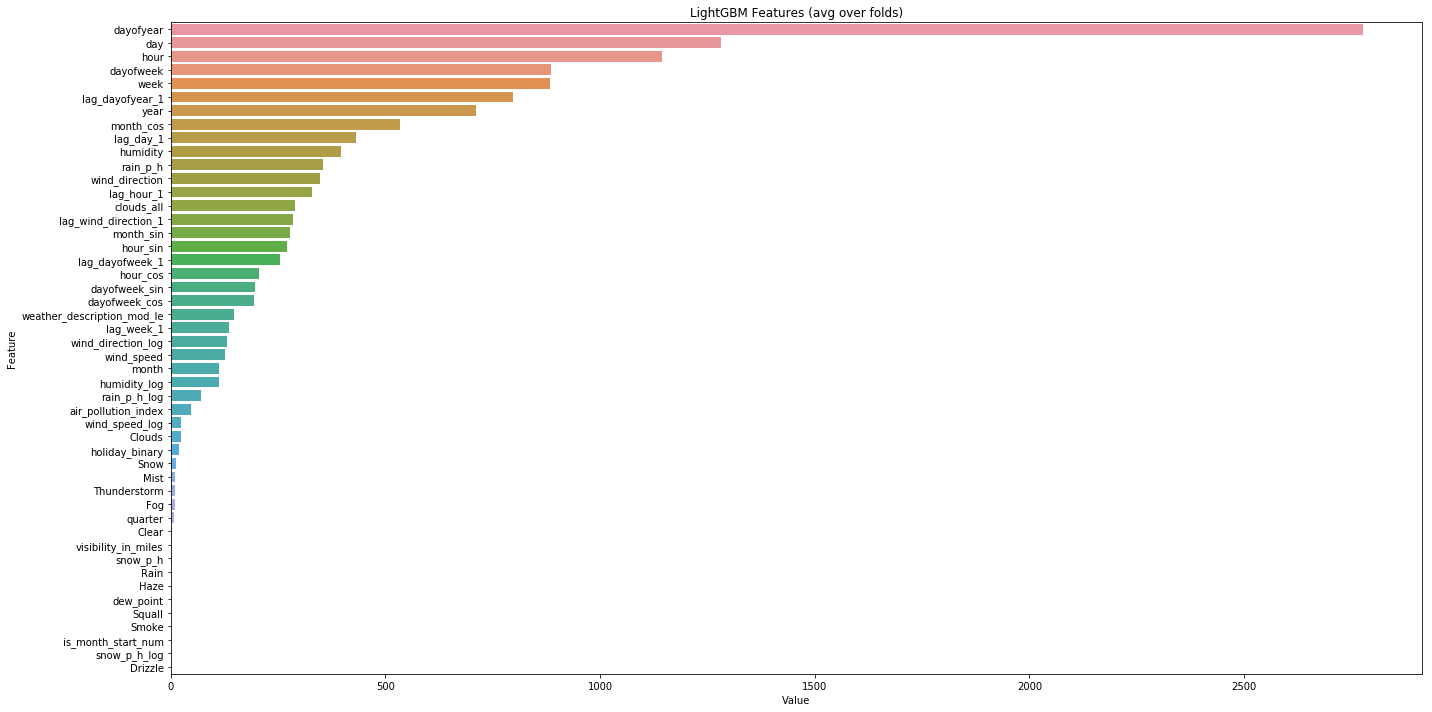

In [9]:
# Show feature importance using LGBM
clf = LGBMRegressor(n_jobs=-1, random_state=42, 
                                bagging_fraction=0.5,
                                boosting='gbdt',
                                feature_fraction=0.8300000000000001,
                                lambda_l1=0.007669606011444036,
                                lambda_l2=3.2158737408403093,
                                learning_rate=0.060535718140078104,
                                max_bin=209,
                                max_depth=21,
                                metric='RMSE',
                                min_data_in_bin=87,
                                min_data_in_leaf=11,
                                min_gain_to_split=0.1,
                                num_leaves=154,
                                objective='tweedie',
                                subsample=0.5099578890687834)
clf.fit(train_X, train_Y)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,train_X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [10]:
# Show feature importance using ELI5
from eli5.lightgbm import explain_weights_lightgbm

explain_weights_lightgbm(clf, top=None)

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Weight,Feature
0.6627,hour
0.1657,hour_cos
0.0656,dayofweek
0.0563,hour_sin
0.0088,dayofyear
0.0073,day
0.0071,lag_hour_1
0.0038,week
0.0032,rain_p_h
0.0022,dayofweek_sin
